In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import keras.models
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LeakyReLU 
from keras.utils.vis_utils import plot_model
import os
import time
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pydot
import pydotplus
import graphviz

# Data

## Preparation of the data samples.

We want a lognormal distribution, but we also want to vectorize the data samples. This is to mimic the situtation we eventually want to consider, which is the qGANs architecture. In the qGAN architecture, we are going to have $2^n$ values to work with (with n being the number of qubits), so we model the target distribution by establishing bins for each value to go into. Here, the binning process is simple, where we put values into bins linearly from 0 - 15, where the last bin contains all the values beyond 15 (hence the small peak at the end).

In [2]:
# Number training data samples
N = 10000000

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
data = np.random.lognormal(mean=mu, sigma=sigma, size=N)

(array([1587151., 2207397., 1596390., 1110967.,  784647.,  569120.,
         422124.,  319457.,  246477.,  192347.,  152399.,  122502.,
         100405.,   81958.,   67809.,  438850.]),
 array([ 0.    ,  0.9375,  1.875 ,  2.8125,  3.75  ,  4.6875,  5.625 ,
         6.5625,  7.5   ,  8.4375,  9.375 , 10.3125, 11.25  , 12.1875,
        13.125 , 14.0625, 15.    ]),
 <BarContainer object of 16 artists>)

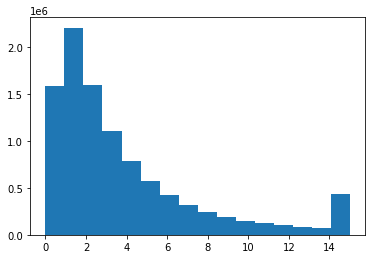

In [3]:
# Split into bins
bins = np.linspace(0, 15, num=16 )
bin_indices = np.digitize(data, bins) - 1

# Vectorize 
data_temp = ((np.arange(16) == bin_indices[:,None]).astype(int))

# Visualization of the bins
plt.hist(bin_indices, bins = 16)

## Processing the data

To process the data in the style that we want to use for the qGANs, we want each data point considered to be representative of the probability distribution. Hence, we combine the data above by the thousand and normalize it, using that as a data point. This allows for statistical fluctuations similar to samples from a probability distribution (because this is exactly what that is) or statistical fluctuations from measuring a quantum circuit with shots. 

In [4]:
data_process = []
for i in range(int(N/1000)):
    new_point = np.sum(data_temp[i*1000:(i+1)*1000], axis = 0)/1000
    data_process.append(new_point)
data_processed = np.array(data_process)
data_processed[0:3]

array([[0.152, 0.239, 0.147, 0.108, 0.08 , 0.058, 0.037, 0.033, 0.025,
        0.017, 0.009, 0.016, 0.012, 0.008, 0.008, 0.051],
       [0.159, 0.205, 0.144, 0.112, 0.093, 0.064, 0.044, 0.031, 0.026,
        0.017, 0.017, 0.009, 0.006, 0.009, 0.007, 0.057],
       [0.153, 0.222, 0.148, 0.093, 0.076, 0.062, 0.053, 0.038, 0.025,
        0.028, 0.015, 0.012, 0.014, 0.012, 0.005, 0.044]])

In [5]:
# Load the data with a batch size of one's choosing
BATCH_SIZE = 100
data_loader = DataLoader(data_processed, batch_size=BATCH_SIZE, shuffle=True)

Another possibility is that if we do not want the statistical fluctuations at all, we can just simply use the same data point for the entire "true" set of data.  

# Networks

## Discriminator

Here we define a simple discriminator model:

In [6]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(64))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1, activation=tf.nn.sigmoid))

    return model

In [7]:
discriminator = make_discriminator_model()

## Generator 

Here we define a simple generator model:

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(16,)))
    
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))

    model.add(Dense(16))

    return model

In [9]:
generator = make_generator_model()

# Loss functions

For the loss functions, we use Binary Cross Entropy for both discriminator and generator.

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [12]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers 

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Training

In [14]:
EPOCHS = 400
noise_dim = 16
num_examples_to_generate = 100
#BUFFER_SIZE = 60000


# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [15]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [16]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        if (epoch % 20 == 0):
            test_data = generator(seed, training=False).numpy()
            fig = plt.figure()
            ax = fig.add_axes([0,0,1,1])
            y = range(16)
            ax.bar(y, test_data[0] )
            plt.show()
        
        for n_batch, batch in enumerate(dataset):
            X_batch = batch.reshape(100,16)
            train_step(X_batch)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  # display.clear_output(wait=True)
  # generate_and_save_images(generator,epochs, seed)

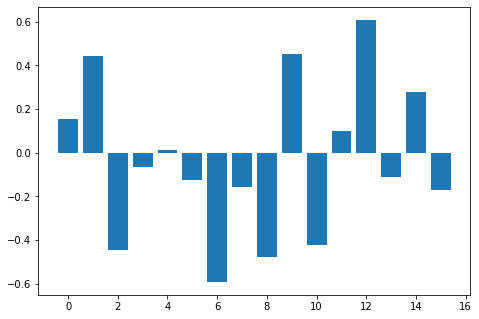

Time for epoch 1 is 1.1014370918273926 sec
Time for epoch 2 is 0.12302827835083008 sec
Time for epoch 3 is 0.10974693298339844 sec
Time for epoch 4 is 0.10518264770507812 sec
Time for epoch 5 is 0.11382174491882324 sec
Time for epoch 6 is 0.11064720153808594 sec
Time for epoch 7 is 0.10489821434020996 sec
Time for epoch 8 is 0.17225170135498047 sec
Time for epoch 9 is 0.0997779369354248 sec
Time for epoch 10 is 0.09560537338256836 sec
Time for epoch 11 is 0.11989831924438477 sec
Time for epoch 12 is 0.09409379959106445 sec
Time for epoch 13 is 0.10058093070983887 sec
Time for epoch 14 is 0.11595368385314941 sec
Time for epoch 15 is 0.10742592811584473 sec
Time for epoch 16 is 0.11474323272705078 sec
Time for epoch 17 is 0.1244657039642334 sec
Time for epoch 18 is 0.1388864517211914 sec
Time for epoch 19 is 0.11153531074523926 sec
Time for epoch 20 is 0.10773134231567383 sec


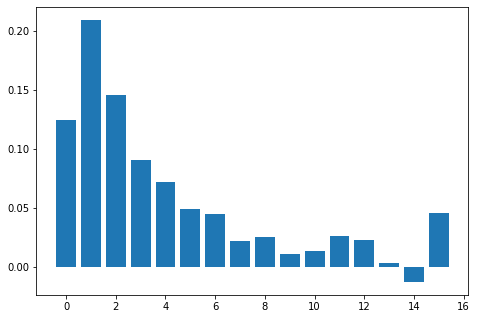

Time for epoch 21 is 0.22522330284118652 sec
Time for epoch 22 is 0.11036205291748047 sec
Time for epoch 23 is 0.09881043434143066 sec
Time for epoch 24 is 0.1054983139038086 sec
Time for epoch 25 is 0.11116886138916016 sec
Time for epoch 26 is 0.11992859840393066 sec
Time for epoch 27 is 0.13254880905151367 sec
Time for epoch 28 is 0.10111260414123535 sec
Time for epoch 29 is 0.11301326751708984 sec
Time for epoch 30 is 0.10437250137329102 sec
Time for epoch 31 is 0.09956121444702148 sec
Time for epoch 32 is 0.11122727394104004 sec
Time for epoch 33 is 0.10887622833251953 sec
Time for epoch 34 is 0.12529349327087402 sec
Time for epoch 35 is 0.12378287315368652 sec
Time for epoch 36 is 0.1424882411956787 sec
Time for epoch 37 is 0.11441445350646973 sec
Time for epoch 38 is 0.13089609146118164 sec
Time for epoch 39 is 0.1229095458984375 sec
Time for epoch 40 is 0.10314440727233887 sec


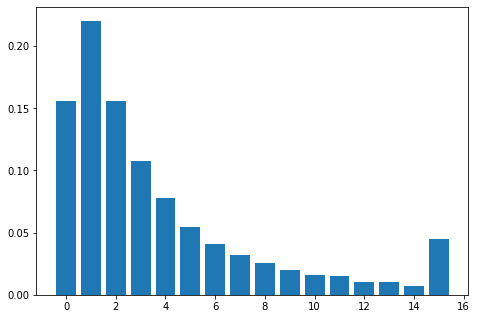

Time for epoch 41 is 0.2073836326599121 sec
Time for epoch 42 is 0.09927010536193848 sec
Time for epoch 43 is 0.11649823188781738 sec
Time for epoch 44 is 0.11158204078674316 sec
Time for epoch 45 is 0.13097500801086426 sec
Time for epoch 46 is 0.11280131340026855 sec
Time for epoch 47 is 0.11907792091369629 sec
Time for epoch 48 is 0.10813713073730469 sec
Time for epoch 49 is 0.09458112716674805 sec
Time for epoch 50 is 0.10018515586853027 sec
Time for epoch 51 is 0.11720871925354004 sec
Time for epoch 52 is 0.10639572143554688 sec
Time for epoch 53 is 0.09255623817443848 sec
Time for epoch 54 is 0.1208639144897461 sec
Time for epoch 55 is 0.14856767654418945 sec
Time for epoch 56 is 0.11202263832092285 sec
Time for epoch 57 is 0.12127685546875 sec
Time for epoch 58 is 0.11407876014709473 sec
Time for epoch 59 is 0.10270285606384277 sec
Time for epoch 60 is 0.09620785713195801 sec


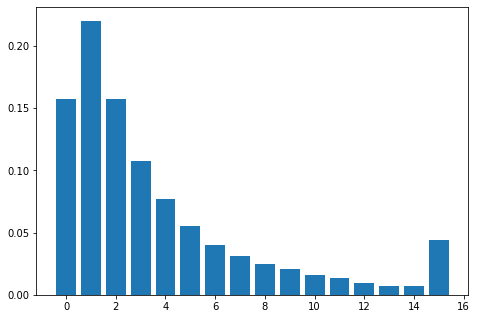

Time for epoch 61 is 0.23886823654174805 sec
Time for epoch 62 is 0.11956501007080078 sec
Time for epoch 63 is 0.12480640411376953 sec
Time for epoch 64 is 0.13014674186706543 sec
Time for epoch 65 is 0.11263632774353027 sec
Time for epoch 66 is 0.10306453704833984 sec
Time for epoch 67 is 0.11529159545898438 sec
Time for epoch 68 is 0.09737920761108398 sec
Time for epoch 69 is 0.09718751907348633 sec
Time for epoch 70 is 0.10916018486022949 sec
Time for epoch 71 is 0.11907744407653809 sec
Time for epoch 72 is 0.10806441307067871 sec
Time for epoch 73 is 0.14585018157958984 sec
Time for epoch 74 is 0.10391402244567871 sec
Time for epoch 75 is 0.11855340003967285 sec
Time for epoch 76 is 0.1049196720123291 sec
Time for epoch 77 is 0.09835457801818848 sec
Time for epoch 78 is 0.1004638671875 sec
Time for epoch 79 is 0.09929442405700684 sec
Time for epoch 80 is 0.10762834548950195 sec


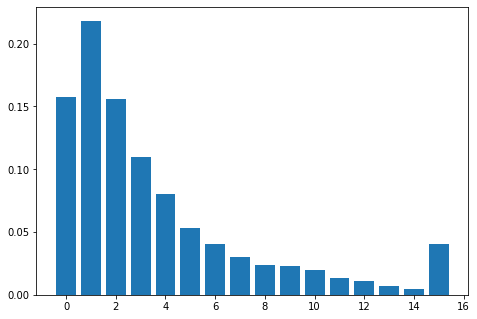

Time for epoch 81 is 0.21186375617980957 sec
Time for epoch 82 is 0.12490129470825195 sec
Time for epoch 83 is 0.1315758228302002 sec
Time for epoch 84 is 0.1007235050201416 sec
Time for epoch 85 is 0.11452627182006836 sec
Time for epoch 86 is 0.08724713325500488 sec
Time for epoch 87 is 0.11726856231689453 sec
Time for epoch 88 is 0.10690784454345703 sec
Time for epoch 89 is 0.11056637763977051 sec
Time for epoch 90 is 0.10805368423461914 sec
Time for epoch 91 is 0.11018514633178711 sec
Time for epoch 92 is 0.1351778507232666 sec
Time for epoch 93 is 0.11882400512695312 sec
Time for epoch 94 is 0.11403393745422363 sec
Time for epoch 95 is 0.1135246753692627 sec
Time for epoch 96 is 0.10762906074523926 sec
Time for epoch 97 is 0.11375927925109863 sec
Time for epoch 98 is 0.09660458564758301 sec
Time for epoch 99 is 0.12184739112854004 sec
Time for epoch 100 is 0.10764193534851074 sec


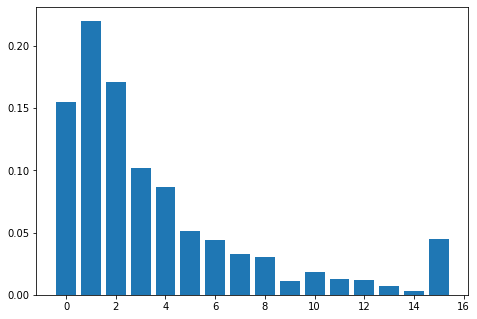

Time for epoch 101 is 0.2586820125579834 sec
Time for epoch 102 is 0.11185431480407715 sec
Time for epoch 103 is 0.11031365394592285 sec
Time for epoch 104 is 0.1100316047668457 sec
Time for epoch 105 is 0.10466551780700684 sec
Time for epoch 106 is 0.10807251930236816 sec
Time for epoch 107 is 0.11278486251831055 sec
Time for epoch 108 is 0.10260891914367676 sec
Time for epoch 109 is 0.11046123504638672 sec
Time for epoch 110 is 0.11416053771972656 sec
Time for epoch 111 is 0.14303350448608398 sec
Time for epoch 112 is 0.11542129516601562 sec
Time for epoch 113 is 0.1024007797241211 sec
Time for epoch 114 is 0.10622358322143555 sec
Time for epoch 115 is 0.10877013206481934 sec
Time for epoch 116 is 0.10274577140808105 sec
Time for epoch 117 is 0.11122345924377441 sec
Time for epoch 118 is 0.10544323921203613 sec
Time for epoch 119 is 0.10470819473266602 sec
Time for epoch 120 is 0.11217045783996582 sec


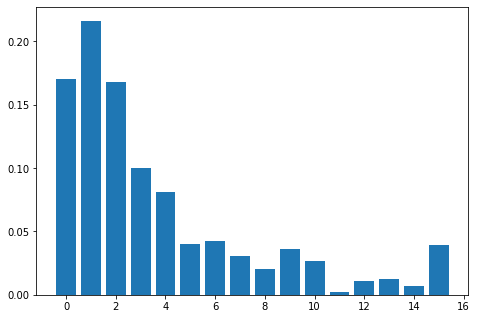

Time for epoch 121 is 0.2476663589477539 sec
Time for epoch 122 is 0.10479307174682617 sec
Time for epoch 123 is 0.11430811882019043 sec
Time for epoch 124 is 0.11490511894226074 sec
Time for epoch 125 is 0.10503125190734863 sec
Time for epoch 126 is 0.11000561714172363 sec
Time for epoch 127 is 0.11196064949035645 sec
Time for epoch 128 is 0.10836553573608398 sec
Time for epoch 129 is 0.10001707077026367 sec
Time for epoch 130 is 0.13686561584472656 sec
Time for epoch 131 is 0.11096525192260742 sec
Time for epoch 132 is 0.09367966651916504 sec
Time for epoch 133 is 0.11219000816345215 sec
Time for epoch 134 is 0.1088399887084961 sec
Time for epoch 135 is 0.11009883880615234 sec
Time for epoch 136 is 0.09157419204711914 sec
Time for epoch 137 is 0.1184396743774414 sec
Time for epoch 138 is 0.11246252059936523 sec
Time for epoch 139 is 0.10143876075744629 sec
Time for epoch 140 is 0.14274191856384277 sec


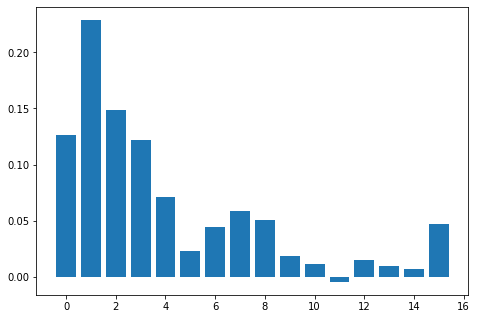

Time for epoch 141 is 0.2030165195465088 sec
Time for epoch 142 is 0.10465359687805176 sec
Time for epoch 143 is 0.11610722541809082 sec
Time for epoch 144 is 0.10469627380371094 sec
Time for epoch 145 is 0.09619617462158203 sec
Time for epoch 146 is 0.11296248435974121 sec
Time for epoch 147 is 0.09625840187072754 sec
Time for epoch 148 is 0.0953531265258789 sec
Time for epoch 149 is 0.14780569076538086 sec
Time for epoch 150 is 0.1273965835571289 sec
Time for epoch 151 is 0.10796952247619629 sec
Time for epoch 152 is 0.11687970161437988 sec
Time for epoch 153 is 0.10508131980895996 sec
Time for epoch 154 is 0.09834933280944824 sec
Time for epoch 155 is 0.09825468063354492 sec
Time for epoch 156 is 0.11649560928344727 sec
Time for epoch 157 is 0.11446118354797363 sec
Time for epoch 158 is 0.10321760177612305 sec
Time for epoch 159 is 0.1335306167602539 sec
Time for epoch 160 is 0.1095113754272461 sec


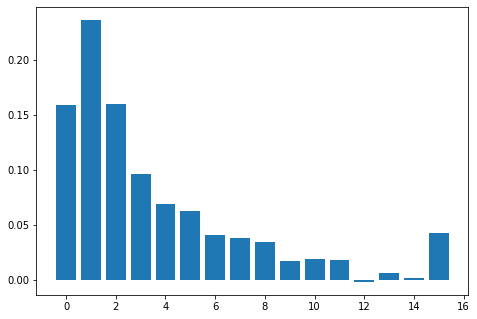

Time for epoch 161 is 0.20368647575378418 sec
Time for epoch 162 is 0.1018378734588623 sec
Time for epoch 163 is 0.10256433486938477 sec
Time for epoch 164 is 0.09795546531677246 sec
Time for epoch 165 is 0.09911274909973145 sec
Time for epoch 166 is 0.1157221794128418 sec
Time for epoch 167 is 0.10612058639526367 sec
Time for epoch 168 is 0.1069173812866211 sec
Time for epoch 169 is 0.13900136947631836 sec
Time for epoch 170 is 0.10348343849182129 sec
Time for epoch 171 is 0.10686421394348145 sec
Time for epoch 172 is 0.11419248580932617 sec
Time for epoch 173 is 0.10258221626281738 sec
Time for epoch 174 is 0.11162328720092773 sec
Time for epoch 175 is 0.1104433536529541 sec
Time for epoch 176 is 0.0984044075012207 sec
Time for epoch 177 is 0.11498808860778809 sec
Time for epoch 178 is 0.10277414321899414 sec
Time for epoch 179 is 0.13446807861328125 sec
Time for epoch 180 is 0.10263252258300781 sec


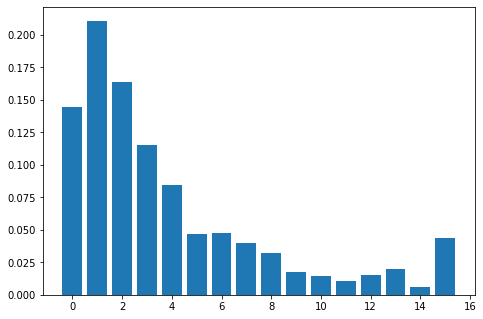

Time for epoch 181 is 0.23192167282104492 sec
Time for epoch 182 is 0.10397815704345703 sec
Time for epoch 183 is 0.09600138664245605 sec
Time for epoch 184 is 0.09254956245422363 sec
Time for epoch 185 is 0.11334538459777832 sec
Time for epoch 186 is 0.09981846809387207 sec
Time for epoch 187 is 0.09650325775146484 sec
Time for epoch 188 is 0.1517939567565918 sec
Time for epoch 189 is 0.10425877571105957 sec
Time for epoch 190 is 0.1060478687286377 sec
Time for epoch 191 is 0.08965134620666504 sec
Time for epoch 192 is 0.11806893348693848 sec
Time for epoch 193 is 0.10537099838256836 sec
Time for epoch 194 is 0.09317207336425781 sec
Time for epoch 195 is 0.11441278457641602 sec
Time for epoch 196 is 0.10458731651306152 sec
Time for epoch 197 is 0.09729599952697754 sec
Time for epoch 198 is 0.1616373062133789 sec
Time for epoch 199 is 0.09291410446166992 sec
Time for epoch 200 is 0.10938239097595215 sec


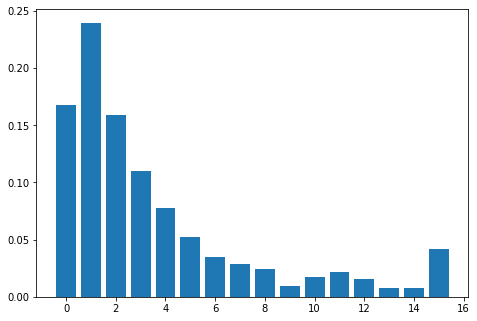

Time for epoch 201 is 0.20293450355529785 sec
Time for epoch 202 is 0.11881446838378906 sec
Time for epoch 203 is 0.10547518730163574 sec
Time for epoch 204 is 0.09226489067077637 sec
Time for epoch 205 is 0.10600042343139648 sec
Time for epoch 206 is 0.10906863212585449 sec
Time for epoch 207 is 0.1245577335357666 sec
Time for epoch 208 is 0.13043832778930664 sec
Time for epoch 209 is 0.10445737838745117 sec
Time for epoch 210 is 0.10342717170715332 sec
Time for epoch 211 is 0.08854556083679199 sec
Time for epoch 212 is 0.11566400527954102 sec
Time for epoch 213 is 0.10235881805419922 sec
Time for epoch 214 is 0.09989380836486816 sec
Time for epoch 215 is 0.0999288558959961 sec
Time for epoch 216 is 0.11595273017883301 sec
Time for epoch 217 is 0.11361050605773926 sec
Time for epoch 218 is 0.1427440643310547 sec
Time for epoch 219 is 0.10205650329589844 sec
Time for epoch 220 is 0.09451580047607422 sec


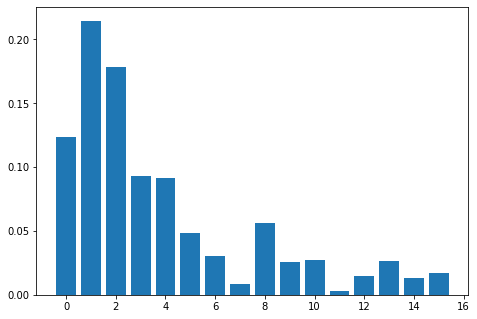

Time for epoch 221 is 0.20739221572875977 sec
Time for epoch 222 is 0.10361933708190918 sec
Time for epoch 223 is 0.1153559684753418 sec
Time for epoch 224 is 0.10632133483886719 sec
Time for epoch 225 is 0.1094508171081543 sec
Time for epoch 226 is 0.10901761054992676 sec
Time for epoch 227 is 0.13271117210388184 sec
Time for epoch 228 is 0.09757113456726074 sec
Time for epoch 229 is 0.103179931640625 sec
Time for epoch 230 is 0.10628366470336914 sec
Time for epoch 231 is 0.08695602416992188 sec
Time for epoch 232 is 0.10791611671447754 sec
Time for epoch 233 is 0.10888910293579102 sec
Time for epoch 234 is 0.10090875625610352 sec
Time for epoch 235 is 0.10580086708068848 sec
Time for epoch 236 is 0.09006905555725098 sec
Time for epoch 237 is 0.14281368255615234 sec
Time for epoch 238 is 0.09967803955078125 sec
Time for epoch 239 is 0.10786938667297363 sec
Time for epoch 240 is 0.09236955642700195 sec


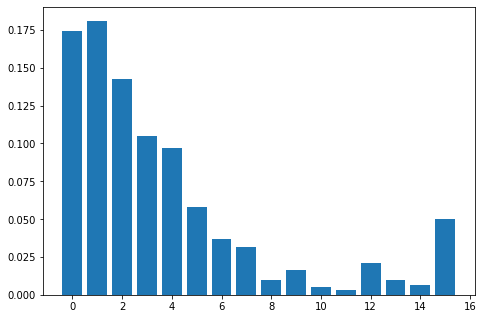

Time for epoch 241 is 0.2325589656829834 sec
Time for epoch 242 is 0.09990859031677246 sec
Time for epoch 243 is 0.11317133903503418 sec
Time for epoch 244 is 0.10281944274902344 sec
Time for epoch 245 is 0.10101079940795898 sec
Time for epoch 246 is 0.11158275604248047 sec
Time for epoch 247 is 0.1295781135559082 sec
Time for epoch 248 is 0.10070967674255371 sec
Time for epoch 249 is 0.09962725639343262 sec
Time for epoch 250 is 0.09992575645446777 sec
Time for epoch 251 is 0.11660957336425781 sec
Time for epoch 252 is 0.10564899444580078 sec
Time for epoch 253 is 0.10434317588806152 sec
Time for epoch 254 is 0.08962583541870117 sec
Time for epoch 255 is 0.10039663314819336 sec
Time for epoch 256 is 0.12065267562866211 sec
Time for epoch 257 is 0.134415864944458 sec
Time for epoch 258 is 0.09828066825866699 sec
Time for epoch 259 is 0.1113286018371582 sec
Time for epoch 260 is 0.10319137573242188 sec


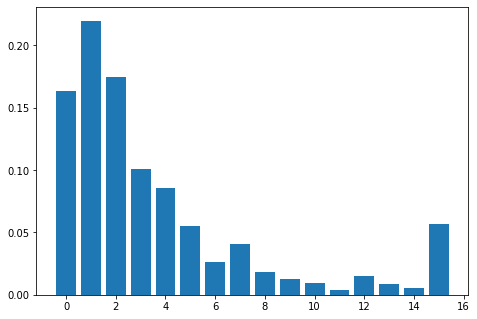

Time for epoch 261 is 0.21695828437805176 sec
Time for epoch 262 is 0.09995293617248535 sec
Time for epoch 263 is 0.1005246639251709 sec
Time for epoch 264 is 0.0996391773223877 sec
Time for epoch 265 is 0.11777853965759277 sec
Time for epoch 266 is 0.14383530616760254 sec
Time for epoch 267 is 0.0935511589050293 sec
Time for epoch 268 is 0.116058349609375 sec
Time for epoch 269 is 0.10446619987487793 sec
Time for epoch 270 is 0.10299372673034668 sec
Time for epoch 271 is 0.10628080368041992 sec
Time for epoch 272 is 0.09327864646911621 sec
Time for epoch 273 is 0.11612081527709961 sec
Time for epoch 274 is 0.10366702079772949 sec
Time for epoch 275 is 0.10273098945617676 sec
Time for epoch 276 is 0.12269973754882812 sec
Time for epoch 277 is 0.11036419868469238 sec
Time for epoch 278 is 0.11539125442504883 sec
Time for epoch 279 is 0.10028982162475586 sec
Time for epoch 280 is 0.0997321605682373 sec


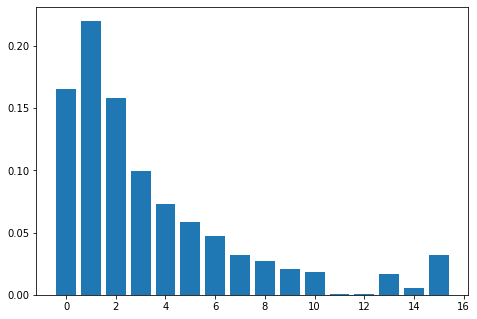

Time for epoch 281 is 0.20174646377563477 sec
Time for epoch 282 is 0.1084597110748291 sec
Time for epoch 283 is 0.10905957221984863 sec
Time for epoch 284 is 0.0985419750213623 sec
Time for epoch 285 is 0.10134649276733398 sec
Time for epoch 286 is 0.13416194915771484 sec
Time for epoch 287 is 0.11571311950683594 sec
Time for epoch 288 is 0.1025688648223877 sec
Time for epoch 289 is 0.0987708568572998 sec
Time for epoch 290 is 0.10214424133300781 sec
Time for epoch 291 is 0.09665513038635254 sec
Time for epoch 292 is 0.11862492561340332 sec
Time for epoch 293 is 0.1032857894897461 sec
Time for epoch 294 is 0.09445357322692871 sec
Time for epoch 295 is 0.10157275199890137 sec
Time for epoch 296 is 0.15311360359191895 sec
Time for epoch 297 is 0.09887504577636719 sec
Time for epoch 298 is 0.09839534759521484 sec
Time for epoch 299 is 0.11679434776306152 sec
Time for epoch 300 is 0.10026335716247559 sec


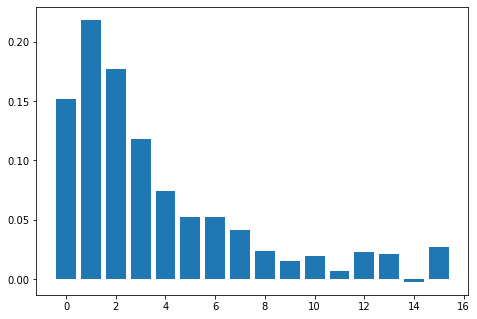

Time for epoch 301 is 0.2158982753753662 sec
Time for epoch 302 is 0.1002960205078125 sec
Time for epoch 303 is 0.11615514755249023 sec
Time for epoch 304 is 0.0997927188873291 sec
Time for epoch 305 is 0.11227035522460938 sec
Time for epoch 306 is 0.1319103240966797 sec
Time for epoch 307 is 0.10355639457702637 sec
Time for epoch 308 is 0.10370707511901855 sec
Time for epoch 309 is 0.1080927848815918 sec
Time for epoch 310 is 0.10572981834411621 sec
Time for epoch 311 is 0.10729432106018066 sec
Time for epoch 312 is 0.10373926162719727 sec
Time for epoch 313 is 0.10231161117553711 sec
Time for epoch 314 is 0.11060428619384766 sec
Time for epoch 315 is 0.1092841625213623 sec
Time for epoch 316 is 0.12472200393676758 sec
Time for epoch 317 is 0.11419320106506348 sec
Time for epoch 318 is 0.10709714889526367 sec
Time for epoch 319 is 0.09191203117370605 sec
Time for epoch 320 is 0.12036561965942383 sec


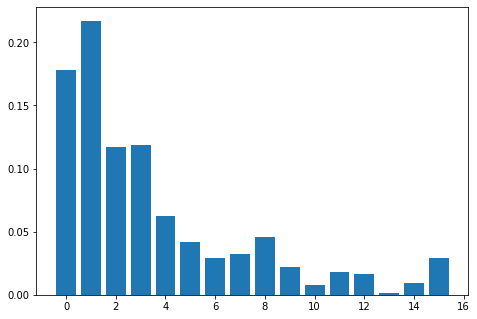

Time for epoch 321 is 0.21333694458007812 sec
Time for epoch 322 is 0.10125589370727539 sec
Time for epoch 323 is 0.11066246032714844 sec
Time for epoch 324 is 0.10345792770385742 sec
Time for epoch 325 is 0.1391451358795166 sec
Time for epoch 326 is 0.09323239326477051 sec
Time for epoch 327 is 0.0975496768951416 sec
Time for epoch 328 is 0.10892581939697266 sec
Time for epoch 329 is 0.11201357841491699 sec
Time for epoch 330 is 0.10722827911376953 sec
Time for epoch 331 is 0.09180235862731934 sec
Time for epoch 332 is 0.10402989387512207 sec
Time for epoch 333 is 0.10918235778808594 sec
Time for epoch 334 is 0.10028958320617676 sec
Time for epoch 335 is 0.1589207649230957 sec
Time for epoch 336 is 0.09430527687072754 sec
Time for epoch 337 is 0.11083149909973145 sec
Time for epoch 338 is 0.10613584518432617 sec
Time for epoch 339 is 0.1001443862915039 sec
Time for epoch 340 is 0.09857845306396484 sec


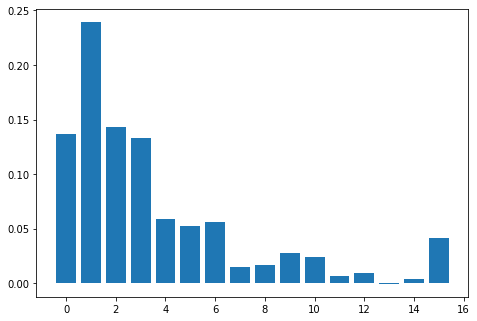

Time for epoch 341 is 0.22057151794433594 sec
Time for epoch 342 is 0.09703969955444336 sec
Time for epoch 343 is 0.11279082298278809 sec
Time for epoch 344 is 0.12039828300476074 sec
Time for epoch 345 is 0.1012425422668457 sec
Time for epoch 346 is 0.11040329933166504 sec
Time for epoch 347 is 0.10589146614074707 sec
Time for epoch 348 is 0.10089397430419922 sec
Time for epoch 349 is 0.1001732349395752 sec
Time for epoch 350 is 0.10010123252868652 sec
Time for epoch 351 is 0.11554384231567383 sec
Time for epoch 352 is 0.10256314277648926 sec
Time for epoch 353 is 0.09796857833862305 sec
Time for epoch 354 is 0.09643745422363281 sec
Time for epoch 355 is 0.1343374252319336 sec
Time for epoch 356 is 0.11090731620788574 sec
Time for epoch 357 is 0.09823369979858398 sec
Time for epoch 358 is 0.09271097183227539 sec
Time for epoch 359 is 0.10504961013793945 sec
Time for epoch 360 is 0.11099576950073242 sec


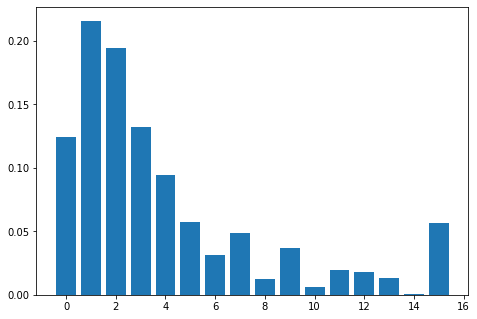

Time for epoch 361 is 0.20315003395080566 sec
Time for epoch 362 is 0.11158418655395508 sec
Time for epoch 363 is 0.10479617118835449 sec
Time for epoch 364 is 0.12059998512268066 sec
Time for epoch 365 is 0.11853194236755371 sec
Time for epoch 366 is 0.11273908615112305 sec
Time for epoch 367 is 0.10447573661804199 sec
Time for epoch 368 is 0.1098017692565918 sec
Time for epoch 369 is 0.10631012916564941 sec
Time for epoch 370 is 0.09454774856567383 sec
Time for epoch 371 is 0.10131430625915527 sec
Time for epoch 372 is 0.1159203052520752 sec
Time for epoch 373 is 0.10251045227050781 sec
Time for epoch 374 is 0.10536623001098633 sec
Time for epoch 375 is 0.12847185134887695 sec
Time for epoch 376 is 0.10174107551574707 sec
Time for epoch 377 is 0.09762763977050781 sec
Time for epoch 378 is 0.1005868911743164 sec
Time for epoch 379 is 0.09954261779785156 sec
Time for epoch 380 is 0.09986400604248047 sec


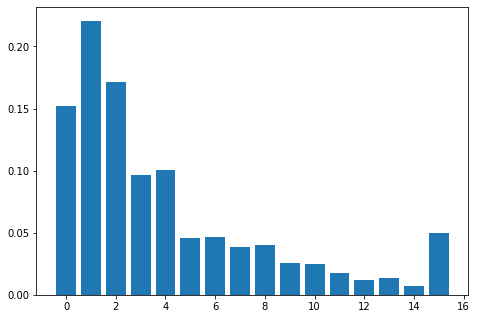

Time for epoch 381 is 0.31683778762817383 sec
Time for epoch 382 is 0.09930419921875 sec
Time for epoch 383 is 0.15513968467712402 sec
Time for epoch 384 is 0.09384989738464355 sec
Time for epoch 385 is 0.10981345176696777 sec
Time for epoch 386 is 0.08662581443786621 sec
Time for epoch 387 is 0.10387611389160156 sec
Time for epoch 388 is 0.10424375534057617 sec
Time for epoch 389 is 0.09452342987060547 sec
Time for epoch 390 is 0.09876012802124023 sec
Time for epoch 391 is 0.10174560546875 sec
Time for epoch 392 is 0.10229635238647461 sec
Time for epoch 393 is 0.11124873161315918 sec
Time for epoch 394 is 0.12372684478759766 sec
Time for epoch 395 is 0.10080432891845703 sec
Time for epoch 396 is 0.09900999069213867 sec
Time for epoch 397 is 0.10017681121826172 sec
Time for epoch 398 is 0.1051788330078125 sec
Time for epoch 399 is 0.09509539604187012 sec
Time for epoch 400 is 0.10316753387451172 sec


In [17]:
train(data_loader, EPOCHS)

In [18]:
noise = tf.random.normal([1, 16])
generated_data = generator(noise, training=False)
generated_data

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[0.15636222, 0.19062161, 0.152796  , 0.09867412, 0.07081036,
        0.05267381, 0.04619094, 0.01184826, 0.02206391, 0.01960746,
        0.01895616, 0.00115889, 0.00283048, 0.01347114, 0.00113368,
        0.03828946]], dtype=float32)>

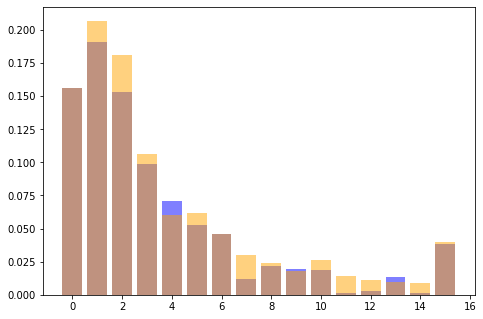

In [25]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
y = range(16)
ax.bar(y, generated_data[0], alpha=0.5, color = "blue")
ax.bar(y, new_point, alpha=0.5, color = "orange")
plt.show()